## Chapter 9 - Hierarchical Models

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn

pandas 1.0.3
numpy 1.18.1
pymc3 3.8
matplotlib 3.1.3
seaborn 0.10.1


### 9.2.3 - Example: Multiple Coins form a Single Mint

In [3]:
# data from coin #1
n_heads1 = 3
n_tails1 = 12

n_flips1 = n_heads1 + n_tails1
data1 = np.repeat([1, 0], [n_heads1, n_tails1])

# coin #2
n_heads2 = 4
n_tails2 = 1

n_flips2 = n_heads2 + n_tails2
data2 = np.repeat([1, 0], [n_heads2, n_tails2])

# now pack all those outcomes into a single vector
outcomes = np.hstack((data1, data2))
# and create a vector of 'coin IDs' so that we can connect each flip
# with the corresponding coin's value of theta
coin = np.hstack((np.zeros_like(data1), np.ones_like(data2)))

In [4]:
# build the model
with pm.Model() as oneminttwocoins_model:
    omega = pm.Beta('omega', 2., 2.)
    # Kruschke uses these parameters in the chapter, but they yield very poor sampling
    #kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa_minus2 = pm.Gamma('kappa_minus2', .5, .5)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)

    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=2)
        
    y = pm.Bernoulli('y', theta[coin], observed=outcomes)

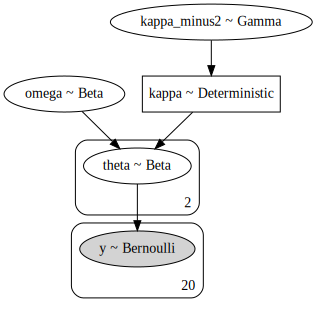

In [5]:
pm.model_to_graphviz(oneminttwocoins_model)

In [6]:
# sample!
with oneminttwocoins_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1000.41draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8890468587412155, but should be close to 0.8. Try to increase the number of tuning steps.


/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

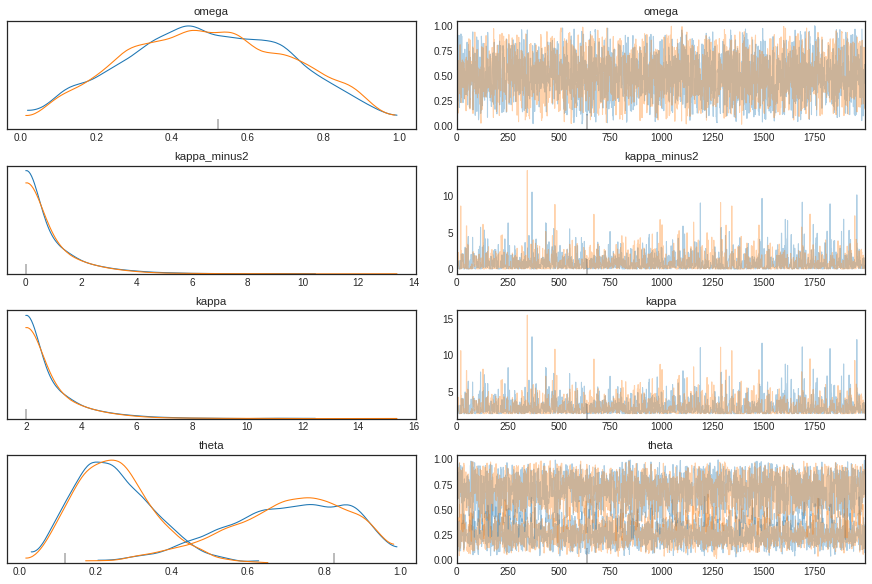

In [7]:
pm.traceplot(trace);

In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.496,0.218,0.099,0.883,0.004,0.003,3699.0,3449.0,3514.0,2397.0,1.0
kappa_minus2,0.859,1.182,0.000,2.926,0.024,0.017,2458.0,2458.0,1483.0,1344.0,1.0
kappa,2.859,1.182,2.000,4.926,0.024,0.017,2458.0,2458.0,1483.0,1344.0,1.0
theta[0],0.250,0.103,0.068,0.441,0.002,0.001,3327.0,3075.0,3252.0,2233.0,1.0
theta[1],0.695,0.163,0.400,0.965,0.003,0.002,2952.0,2949.0,2837.0,2406.0,1.0


Given that this is our first legitimate MCMC trace object, let's see how one can interogate the raw trace to extract information we might want.

In [9]:
trace

<MultiTrace: 2 chains, 2000 iterations, 7 variables>

In [10]:
# let's look at the first MCMC sample
trace[0]

{'omega_logodds__': -0.8315039435478991,
 'kappa_minus2_log__': 0.01384066755777394,
 'theta_logodds__': array([-2.01500276, -0.91224327]),
 'omega': 0.3033271631614011,
 'kappa_minus2': 1.0139368930260595,
 'kappa': 3.0139368930260595,
 'theta': array([0.11763671, 0.28654101])}

Note that theta is 2 variables (one for each coin).  They are stored together, because we asked for an array of theta parameters.  Let's calculate the mean value of the $\theta$ parameter associated with the first coin.

In [11]:
(trace['theta'][:,0]).mean()

0.24994460876172633

And for the second coin.

In [12]:
(trace['theta'][:,1]).mean()

0.6945477579513312

What if we have 'reference' values against which we wish to compare our parameter estimate?  We can, among other things, ask what proportion of samples took on a value greater than/less than that reference value.  In the case of coins, which might wish to compare $\theta$ to a value of 0.5 (i.e., to ask how likely it is that each coin is 'fair').

In [13]:
# coin 1
(trace['theta'][:,0]>.5).mean()

0.01775

In [14]:
# coin 2
(trace['theta'][:,1]>.5).mean()

0.87125

Now let's ask about our mint parameter, $\omega$.  Here too we calculate the mean posterior estimate.

In [15]:
(trace['omega']).mean()

0.495934087540453

We can also again compare $\omega$ against our 'reference' value of 0.5.  The interpretation of $\omega$ is somewhat different than the interpretation of $\theta$.  Asking about $p(\omega > 0.5)$ tells us whether the _mint tends to generate fair coins_.

In [16]:
(trace['omega'] > .5).mean()

0.48925

We can also inspect $\kappa$, which will tell us how consistent the mint is in generating coins with values of $\theta$ near $\omega$.

In [17]:
(trace['kappa']).mean()

2.8593170504097394

### 9.2.4 - Example: Therapeutic touch

In [18]:
df = pd.read_csv('data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   y       280 non-null    int64   
 1   s       280 non-null    category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [19]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

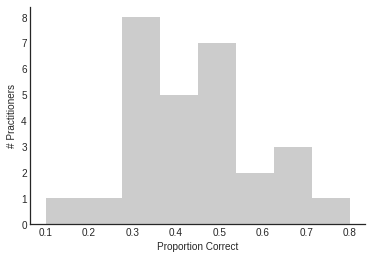

In [20]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

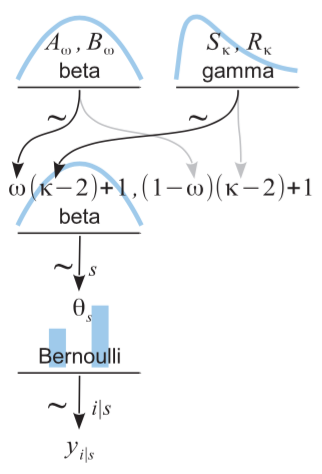

In [21]:
Image('images/fig9_7.png', width=200)

In [22]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)

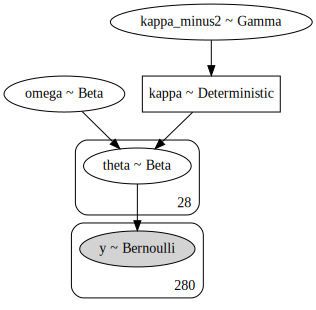

In [23]:
pm.model_to_graphviz(hierarchical_model)

In [24]:
with hierarchical_model:
    trace = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:50<00:00, 433.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


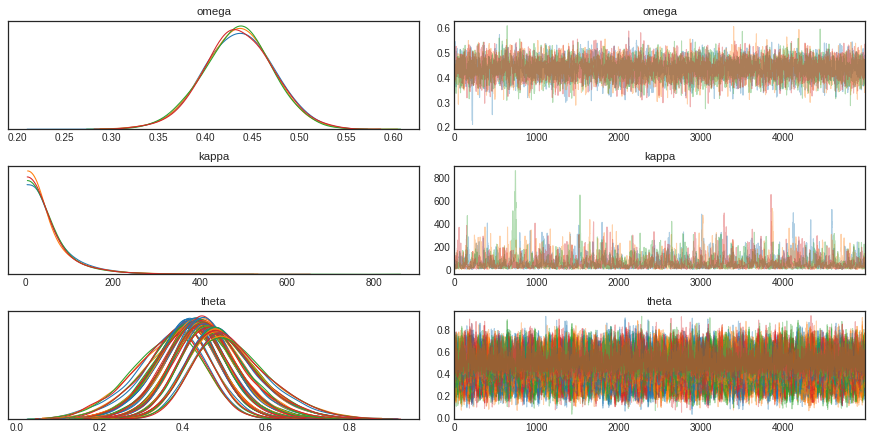

In [25]:
pm.traceplot(trace, ['omega','kappa', 'theta']);

In [26]:
pm.summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
omega,0.435,0.037,0.366,0.504,0.000,0.000,5846.0,5846.0,5790.0,9980.0,1.0
kappa_minus2,55.780,59.421,2.489,156.136,1.569,1.110,1434.0,1434.0,1444.0,3055.0,1.0
kappa,57.780,59.421,4.489,158.136,1.569,1.110,1434.0,1434.0,1444.0,3055.0,1.0
theta[0],0.361,0.087,0.194,0.518,0.001,0.001,4681.0,4681.0,5028.0,7542.0,1.0
theta[1],0.384,0.083,0.222,0.536,0.001,0.001,7028.0,7028.0,7406.0,8852.0,1.0
theta[2],0.407,0.079,0.257,0.558,0.001,0.000,12679.0,12679.0,12921.0,9698.0,1.0
theta[3],0.407,0.079,0.258,0.558,0.001,0.001,11428.0,11428.0,11678.0,10482.0,1.0
theta[4],0.407,0.079,0.253,0.555,0.001,0.001,11803.0,11803.0,12069.0,8364.0,1.0
theta[5],0.408,0.079,0.256,0.555,0.001,0.001,12278.0,12278.0,12495.0,9720.0,1.0
theta[6],0.407,0.079,0.250,0.552,0.001,0.001,11054.0,11054.0,11293.0,8878.0,1.0


#### Figure 9.10 - Marginal posterior distributions

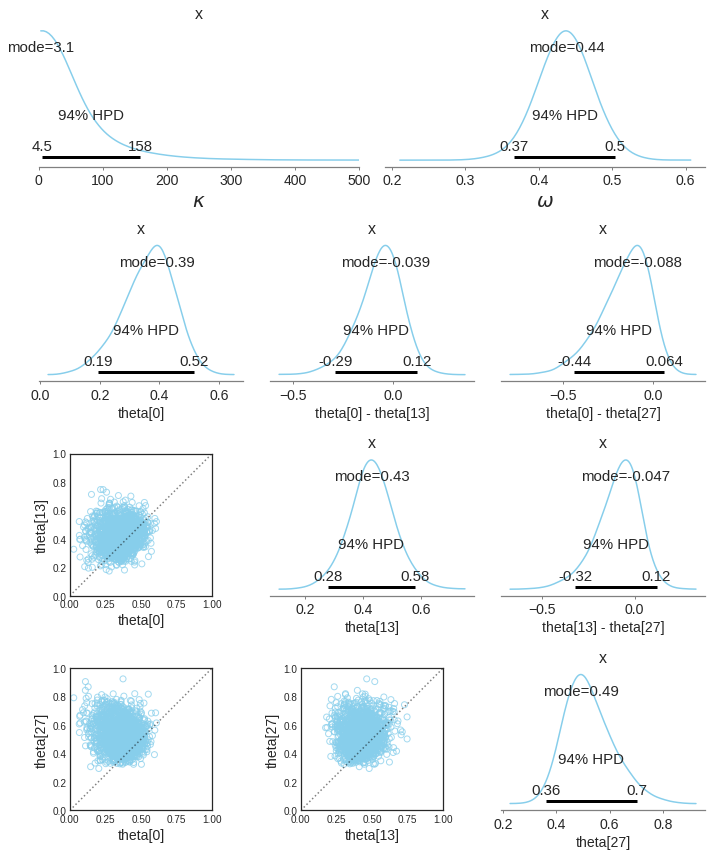

In [27]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    pm.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    pm.plot_posterior(trace['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['theta'][::10,var[0]], trace['theta'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    pm.plot_posterior(trace['theta'][:,var[0]]-trace['theta'][:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

In [28]:
with pm.Model() as unpooled_model:
    
    theta = pm.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)

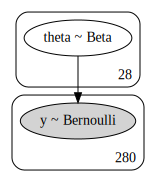

In [29]:
pm.model_to_graphviz(unpooled_model)

In [30]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:20<00:00, 1095.88draws/s]


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [31]:
df_shrinkage = (pd.concat([pm.summary(unpooled_trace).iloc[:,0],
                           pm.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta[0],unpooled,0.166
1,theta[1],unpooled,0.250
2,theta[2],unpooled,0.333
3,theta[3],unpooled,0.334
4,theta[4],unpooled,0.333


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

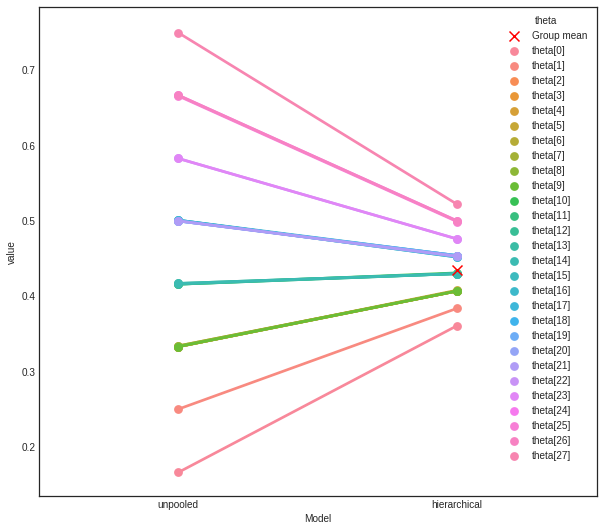

In [32]:
plt.figure(figsize=(10,9))
plt.scatter(1, pm.summary(trace).iloc[0,0], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [33]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
dtypes: category(1), int64(2), object(1)
memory usage: 23.7+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [34]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [35]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

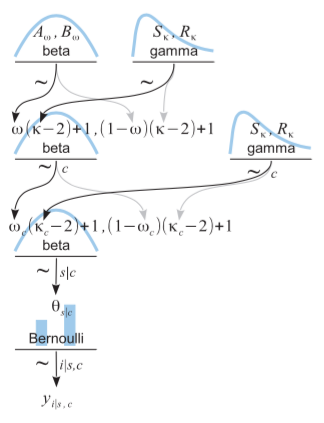

In [36]:
Image('images/fig9_13.png', width=300)

In [37]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

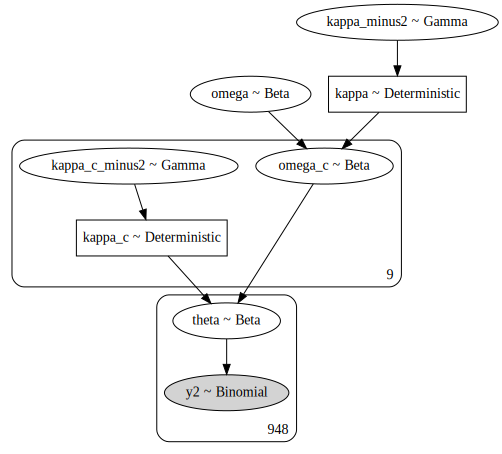

In [38]:
pm.model_to_graphviz(hierarchical_model2)

In [39]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
Sampling 4 chains, 0 divergences: 100%|██████████| 14000/14000 [01:56<00:00, 120.50draws/s]
The number of effective samples is smaller than 10% for some parameters.


/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/xian/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be 

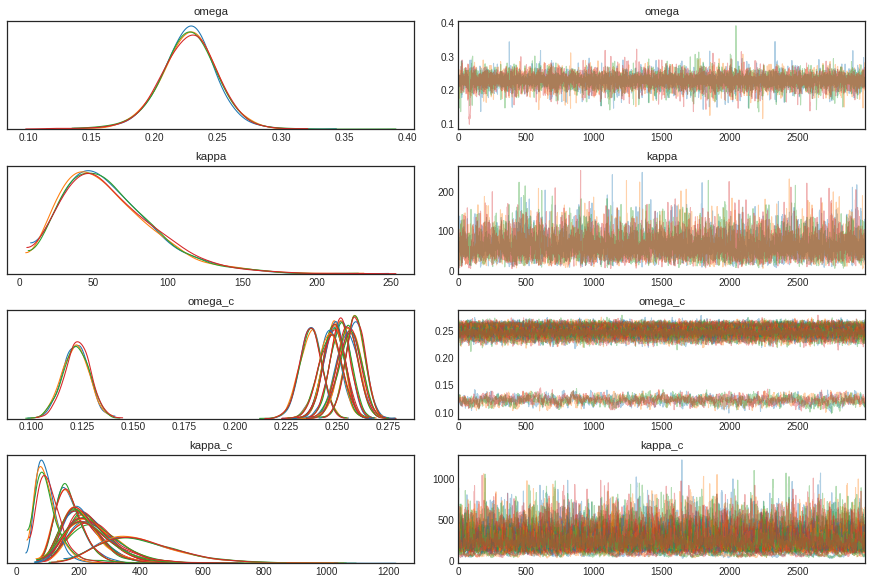

In [40]:
pm.traceplot(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

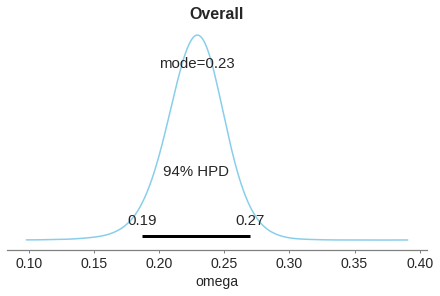

In [41]:
pm.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

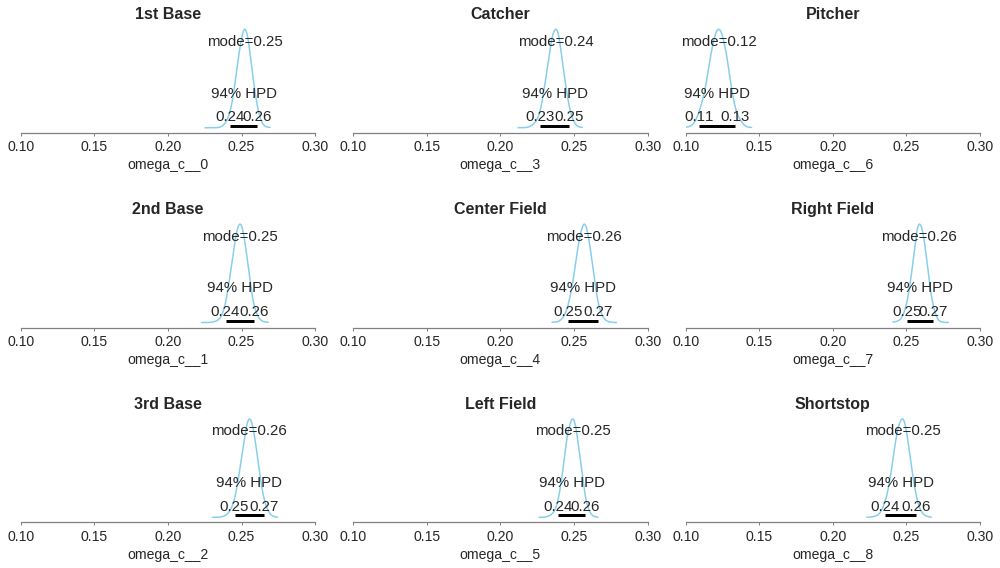

In [42]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)